In [265]:
# Author: AKASH KADEL
# Date: 05/13/2019

### This notebook is divided into four main sections:
1. Baseline data: Training and testing model with basic movie details. <ul><li>Models used : OLS regression , which acts as the baseline</li><li>R2 score obtained is <u>0.01</u></li></ul>
2. Adding director names to the data prepared in the first step. This adds a lot of dimensionailty in the dataset. <ul><li>Models used: OLS, lasso, ridge</li><li>Max R2 score obtained is <u>0.03</u></li></ul>
3. Adding Genres information to the data prepared in the first step.  <ul><li>Models used: OLS, lasso, ridge, Random Forest Regression, Adaboost Regression</li><li>Max R2 score obtained is <u>0.25</u></li></ul>
4. Adding Genres and director information to the data prepared in the first step.  <ul><li>Models used: OLS, lasso, ridge, Random Forest Regression, Adaboost Regression</li><li>Max R2 score obtained is <u>0.26</u></li></ul>


<b> <i><u>Note:</u></i> Due to time and computing contraints, I could try only a limited set of experiments with the data and the hyperparameter values for the algorithms. I have explained more in the Future Section (at the bottom) section

In [122]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import operator

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Reading data:
ratings = pd.read_csv('data/title.ratings.tsv/data.tsv', sep='\t')
title_akas = pd.read_csv('data/title.akas.tsv/data.tsv', sep='\t')
title_principals = pd.read_csv('data/title.principals.tsv/data.tsv', sep='\t')
title_episode = pd.read_csv('data/title.episode.tsv/data.tsv', sep='\t')
title_crew = pd.read_csv('data/title.crew.tsv/data.tsv', sep='\t')
name_basics = pd.read_csv('data/name.basics.tsv/data.tsv', sep='\t')
title_basics = pd.read_csv('data/title.basics.tsv/data.tsv', sep='\t')

## 1. title_akas dataset:

In [2]:
title_akas.head(3)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
1,tt0000001,2,Καρμενσίτα,GR,\N,\N,\N,0
2,tt0000001,3,Карменсита,RU,\N,\N,\N,0


In [3]:
# checking for NA:
title_akas.isna().sum()

titleId             0
ordering            0
title               0
region             55
language            0
types               0
attributes          0
isOriginalTitle     0
dtype: int64

<b>Only region variable has NA values.</b>

In [4]:
# Adding total number of available versions for a movie -> this will be a new feature
title_version_counts = title_akas.copy()
title_version_counts['version_counts'] = title_akas.groupby(['titleId'])['ordering'].transform('count')
title_version_counts = title_version_counts[['titleId', 'version_counts']]
title_version_counts = title_version_counts.drop_duplicates(keep='first').reset_index(drop=True)

## 2. title_basics

In [5]:
title_basics.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


In [6]:
# checking for NA:
title_basics.isna().sum()

tconst            0
titleType         0
primaryTitle      7
originalTitle     7
isAdult           0
startYear         0
endYear           0
runtimeMinutes    0
genres            8
dtype: int64

<b>PrimaryTitle, OriginalTitle and genres variables have NA.<br> 
Among these three, only 'genres' variable play an integral part in determining the rating of the movie</b>

In [7]:
8/len(title_basics)*100

0.00013688614477797324

<b>Now, since the missing value data points correspond to less than 0.001% of the dataset, we can safely drop these rows

In [8]:
title_basics = title_basics.dropna().reset_index(drop=True)

In [9]:
# Creating a mapping dataframe for title and the type -> useful to extract movie titles only
title_and_type_mapping = title_basics.copy()
title_and_type_mapping = title_and_type_mapping[['tconst', 'titleType']]
title_and_type_mapping = title_and_type_mapping.drop_duplicates(keep='first').reset_index(drop=True)

In [10]:
title_and_type_mapping.head(3)

,tconst,titleType
0,tt0000001,short
1,tt0000002,short
2,tt0000003,short


In [11]:
# Adding the version counts for the movie (which was calculated in section 1)
data_titles_complete = pd.merge(title_basics, title_version_counts, how='left', left_on='tconst', right_on='titleId', left_index=True)
data_titles_complete = data_titles_complete.drop(axis=1, columns=['titleId'])

In [12]:
data_titles_complete.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,version_counts
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.0
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.0


In [14]:
# Filtering titles only for movies 
data_titles_only_movies = data_titles_complete[data_titles_complete['titleType'] == 'movie']
data_titles_only_movies = data_titles_only_movies.drop(axis=1, columns=['titleType'])
data_titles_only_movies = data_titles_only_movies.reset_index(drop=True)

In [15]:
data_titles_only_movies.head(3)

,tconst,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,version_counts
0,tt0000009,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,3.0
1,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",3.0
2,tt0000335,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",3.0


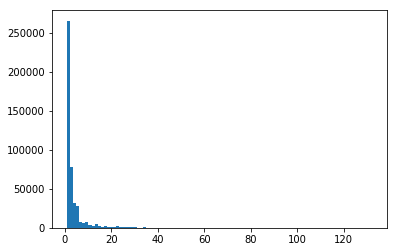

In [284]:
# visualzing the version counts in histogram
x=np.array(data_titles_only_movies['version_counts'])
x = x[~np.isnan(x)]
plt.hist(x, bins=100)
plt.show()

You can see that some movies have more than 20 versions made on them

## 3. Preparing training data to calculate baseline model:


<b> Baseline data only uses few features which are present in the <i>'data_titles_only_movies'</i> table and the <i>'ratings'</i> table

##### 3(a) Utils

In [ ]:
def removeRowsWithEmptyValues(df):
    df = df[df.runtimeMinutes != '\\N']
    df = df[df.startYear != '\\N']
    df = df.reset_index(drop=True)
    return df

def prepareData(df, y_col='averageRating'):
    cols = df.columns.tolist()
    cols.remove(y_col)
    X = df[cols]
    y = df[y_col]
    return X,y

def CrossValidationOnASelectedModel(model, X_train, y_train, alpha_range, split_num=5, score_metric='neg_mean_squared_error'):
    score_list = []
    for alpha in alpha_range:
        func = eval(model)(alpha=alpha)
        score = cross_val_score(func, X_train, y_train, cv=split_num, scoring=score_metric)
        score = np.average(score)
        score_list.append(score)
    return score_list

def getBestHyperparameterVal(score_list, hyperparameter_range):
    idx = np.argmax(score_list)
    hyperparameter_best = hyperparameter_range[idx]
    return hyperparameter_best

def CrossValidationOnASelectedModelII(model, X_train, y_train, n_estimators, split_num=5, score_metric='neg_mean_squared_error'):
    score_list = []
    for estimator in n_estimators:
        func = eval(model)(n_estimators=estimator)
        score = cross_val_score(func, X_train, y_train, cv=split_num, scoring=score_metric)
        score = np.average(score)
        score_list.append(score)
    return score_list

def trainAndTestAModelII(model, n_estimators, X_train, y_train, X_test, y_test):
    func = eval(model)(n_estimators=n_estimators)
    func.fit(X_train, y_train)
    y_pred = func.predict(X_test)
    print("The mean squared error for "+model+" is :", mean_squared_error(y_test, y_pred))
    print("The r2 score for "+model+" is :", r2_score(y_test, y_pred))
    return func

def plotNegativeMSELoss(alpha_range, mse_list, model_name):
    plt.plot(alpha_range, mse_list)
    plt.title(model_name+" Negative MSE Loss")
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.show()

def trainAndTestAModel(model, alpha_val, X_train, y_train, X_test, y_test, alpha_req=False):
    if alpha_req==True:
        func = eval(model)(alpha=alpha_val)
    else:
        func = eval(model)()
    func.fit(X_train, y_train)
    y_pred = func.predict(X_test)
    print("The mean squared error for "+model+" is :", mean_squared_error(y_test, y_pred))
    print("The r2 score for "+model+" is :", r2_score(y_test, y_pred))
    return func

def plotVariablesCoefficients(coefficients, col_names):
    indices = np.arange(0, len(col_names), 1)
    plt.bar(indices, coefficients)
    plt.xticks(indices, col_names, rotation=45)
    plt.show()

##### 3(b) Preparing the dataset

In [16]:
# ratings data:
ratings.head(3)

,tconst,averageRating,numVotes
0,tt0000001,5.8,1497
1,tt0000002,6.3,181
2,tt0000003,6.6,1136


In [17]:
# gather ratings data only for movies:
ratings_with_titles = pd.merge(ratings, title_and_type_mapping, on='tconst', how='left')
ratings_movie = ratings_with_titles[ratings_with_titles['titleType'] == 'movie'].reset_index(drop=True)
ratings_movie.head(3)

,tconst,averageRating,numVotes,titleType
0,tt0000009,5.5,79,movie
1,tt0000147,5.2,291,movie
2,tt0000335,6.3,39,movie


In [18]:
baseline_data = pd.merge(ratings_movie, data_titles_only_movies, on='tconst', how='left')
baseline_data.head(3)

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,version_counts
0,tt0000009,5.5,79,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,3.0
1,tt0000147,5.2,291,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",3.0
2,tt0000335,6.3,39,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",3.0


In [19]:
# remove unnecessary columns:
baseline_data = baseline_data.drop(columns=['titleType','primaryTitle', 'originalTitle', 'endYear', 'genres'])
baseline_data.head(3)

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,version_counts
0,tt0000009,5.5,79,0,1894,45,3.0
1,tt0000147,5.2,291,0,1897,20,3.0
2,tt0000335,6.3,39,0,1900,\N,3.0


In [20]:
# Check for NA
baseline_data.isna().sum()

tconst                0
averageRating         0
numVotes              0
isAdult               0
startYear             0
runtimeMinutes        0
version_counts    13507
dtype: int64

<b> The NA values are because there are missing titles in title_akas.tsv file. This means that they have only one version. Hence the NA values can be replaced by 1

In [21]:
baseline_data = baseline_data.fillna(value={'version_counts':1})

In [22]:
# removing the tconst variable as it gives no meaning during modeling phase
baseline_data = baseline_data.drop(axis=1, columns=['tconst'])

In [23]:
# checking for rows with values '\\N':

(baseline_data == '\\N').sum()

averageRating         0
numVotes              0
isAdult               0
startYear            14
runtimeMinutes    28585
version_counts        0
dtype: int64

In [25]:
baseline_data = removeRowsWithEmptyValues(baseline_data)

In [ ]:
X, y = prepareData(baseline_data, 'averageRating')
# Standardizing the datasets:
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

##### 3(c) Training simple OLS

The mean squared error for LinearRegression is : 1.71435168544
The r2 score for LinearRegression is : 0.00933644777643


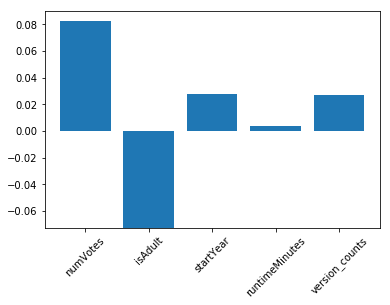

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
model = trainAndTestAModel('LinearRegression', -1, X_train, y_train, X_test, y_test, False)
plotVariablesCoefficients(model.coef_, X.columns.tolist())

<b> The r2 score reported here is nearly 0.01 which is extremely less. This a good motivation to extend the dimensionality of the training dataset in the pursuit of getting a higher r2 score.

## 4. title_crew

In [28]:
title_crew.head(3)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N


In [29]:
# checking for NA:
title_crew.isna().sum()

tconst       0
directors    0
writers      0
dtype: int64

## 5. title_principals

In [30]:
title_principals.head(3)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Herself""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N


<b>We see that title_crew is a subset of title_principals. Because, title_crew contains information for directors and writers, while title_principals contains directors, writers and actors. An example can be seen below too:

In [31]:
title_crew[title_crew['tconst'] == 'tt0000007']

,tconst,directors,writers
6,tt0000007,"nm0374658,nm0005690",\N


In [32]:
title_principals[title_principals['tconst'] == 'tt0000007']

,tconst,ordering,nconst,category,job,characters
16,tt0000007,1,nm0179163,actor,\N,\N
17,tt0000007,2,nm0183947,actor,\N,\N
18,tt0000007,3,nm0005690,director,\N,\N
19,tt0000007,4,nm0374658,director,\N,\N
20,tt0000007,5,nm0249379,producer,producer,\N


<b> We see that output from title_crew is already contained in the output from title_principal

## 6. Forming training dataset which includes the directors of the movie

##### 6(a) Preparing the dataset

In [33]:
# Keeping only the movie related titles:

title_principals_movie = pd.merge(title_principals, title_and_type_mapping, on='tconst', how='left')
title_principals_movie = title_principals_movie[title_principals_movie['titleType'] == 'movie']

In [34]:
# Calculating unique number of directors and actors:

unique_directors = title_principals_movie[title_principals_movie['category'] == 'director']['nconst']
unique_actor = title_principals_movie[title_principals_movie['category'] == 'actor']['nconst']
len(unique_directors), len(unique_actor)

(484115, 1027753)

<b><ul><li>Adding both directors and actors in the training data will make the data very sparse and it makes my the alorithm run for hours to train. 
Hence, I am only adding directors due to time constraint.


In [65]:
# Gathering the ratings data first
data = pd.merge(ratings_movie, data_titles_only_movies, on='tconst', how='left')
data = removeRowsWithEmptyValues(data)

In [66]:
data.head(2)

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,version_counts
0,tt0000009,5.5,79,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,3.0
1,tt0000147,5.2,291,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",3.0


##### 6(b) Preprocessing to add directors

In [67]:
# Calculating the unique directors

title_crew_filtered = title_crew[title_crew['tconst'].isin(data.tconst)]
directors = []
for i in title_crew_filtered.directors:
    if i != '\\N':
        director = i.split(',')
        directors.extend(director)
len(np.unique(directors))

91049

<b><ul><li>Total number of unique directors are 91,049. Storing a dataframe of this size is giving me MemoryError.</li> <li>One trick is to select directors which have directed atleast 30 movies. This reduces the directors count to 516</li></ul>

In [70]:
def filteringDirectors(directors, threshold):
    filtered = []
    directors_count = Counter(directors)
    for i in list(directors_count.keys()):
        if directors_count[i] > threshold:
            filtered.append(i)
    return filtered

In [71]:
directors = filteringDirectors(directors, 30)
len(directors)

516

In [72]:
# Craeting a dataframe for these directors
df_directors = pd.DataFrame(index=data.index, columns=directors)
df_directors = df_directors.fillna(0)

# Removing unnecessary columns and imputing NA values
data = data.drop(columns=['titleType','primaryTitle', 'originalTitle', 'endYear', 'genres'])
data = data.fillna(value={'version_counts':1})

In [73]:
data.head(3)

,tconst,averageRating,numVotes,isAdult,startYear,runtimeMinutes,version_counts
0,tt0000009,5.5,79,0,1894,45,3.0
1,tt0000147,5.2,291,0,1897,20,3.0
2,tt0000574,6.2,508,0,1906,70,4.0


In [74]:
title_directors_mapping = title_crew_filtered[['tconst', 'directors']].set_index('tconst').T.to_dict('list')

In [88]:
for idx, row in data.iterrows():
    title = row['tconst']
    director = title_directors_mapping[title][0]
    director = director.split(',')
    for d in director:
        if d in directors:
            df_directors.iloc[idx][d] = 1

In [113]:
data_with_directors = pd.concat([data, df_directors], axis=1)
data_with_directors = data_with_directors.drop(axis=1, columns=['tconst'])
data_with_directors.head(3)

,averageRating,numVotes,isAdult,startYear,runtimeMinutes,version_counts,nm0947998,nm0950109,nm0043622,nm0166730,...,nm0850466,nm0587741,nm0388648,nm0916125,nm0800373,nm0192698,nm0307819,nm0434189,nm0226189,nm0718469
0,5.5,79,0,1894,45,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.2,291,0,1897,20,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6.2,508,0,1906,70,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
X, y = prepareData(data_with_directors, 'averageRating')
# Standardizing the datasets:
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

##### 6(c) Training and testing ols, lasso and ridge models

<ul>
<li> I am using 5 fold cross validation to understand which model performs the best. This is being done indiviudally for lasso and ridge</li>
<li> CV is done along with a predefined range of alpha values ( the range is np.exp(np.arange(0.001,-10,-0.5)) ) for lasso ad ridge</li>
<li> The data is then trained using the model which performed best for both lasso and ridge</li>
</ul>

In [197]:
# Cross validation on a set of alpha values
alpha_range = np.exp(np.arange(0.001,-10,-0.5))

lasso_score_list = CrossValidationOnASelectedModel('Lasso', X_train, y_train, alpha_range, 5)
ridge_score_list = CrossValidationOnASelectedModel('Ridge', X_train, y_train, alpha_range, 5)

# Extractiong the best alpha
lasso_best_alpha = getBestHyperparameterVal(lasso_score_list, alpha_range)
ridge_best_alpha = getBestHyperparameterVal(ridge_score_list, alpha_range)

In [199]:
# Training various linear regression models

ols = trainAndTestAModel('LinearRegression', -1, X_train, y_train, X_test, y_test, False)
lasso_model = trainAndTestAModel('Lasso', lasso_best_alpha, X_train, y_train, X_test, y_test, True)
ridge_model = trainAndTestAModel('Ridge', ridge_best_alpha, X_train, y_train, X_test, y_test, True)

The mean squared error for LinearRegression is : 1.67586334288
The r2 score for LinearRegression is : 0.0315775074605
The mean squared error for Lasso is : 1.68034688213
The r2 score for Lasso is : 0.0289866277975
The mean squared error for Ridge is : 1.67586332877
The r2 score for Ridge is : 0.0315775156151


<b><ul><li>We see here that the max r2 score obtained is 0.032 which is three times the baseline score (0.01)</li>
<li> We could see that the r2 score is not great enough which means that adding directors didn't help the model much in the prediction task</li>

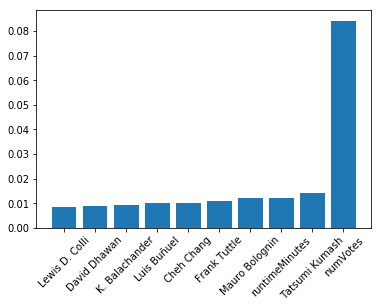

In [261]:
# Visualizing top 10 featurs by lasso coeff:

top_n_idx = lasso_model.coef_.argsort()[-10:]
cols = data_with_directors.columns.tolist()
cols.remove('averageRating')
top_n_feat = np.array(cols)[top_n_idx]
for i in range(len(top_n_feat)):
    if top_n_feat[i] in list(name_basics['nconst']):
        top_n_feat[i] = name_basics[name_basics['nconst']==top_n_feat[i]]['primaryName'].iloc[0]

plt.bar(np.arange(0,len(top_n_idx), 1), lasso_model.coef_[top_n_idx])
plt.xticks(np.arange(0,len(top_n_idx), 1), top_n_feat, rotation=45)
plt.show()

<b> From the above graph we could see that, presence of few of the directors and number of votes given to a movie greatly influences the rating of the movie

# 7. Adding genres as features in the dataset

##### 7(a) preprocessing to add genres in the dataset

In [227]:
# Extracting unique genres for each movie
def extract_unique_genres(df):
    genres = list(df['genres'])
    unique_genres = []
    for i in range(len(genres)):
        s = genres[i].split(',')
        unique_genres.extend(s)
    return np.unique(unique_genres)
unique_genres = extract_unique_genres(data_titles_only_movies)

# Performing one hot encoding on the extracted movie genres
def add_genres_df(genres, genre_df, df):
    for idx, row in df.iterrows():
        genre = row['genres'].split(',')
        for i in genre:
            genre_df[i][idx] = 1
    final = pd.concat([df, genre_df], axis=1)
    return final

In [342]:
index = data_titles_only_movies.index
genre_df = pd.DataFrame(index=index, columns=unique_genres)
genre_df = genre_df.fillna(0)
data_titles_with_genres = add_genres_df(unique_genres, genre_df, data_titles_only_movies)
data_titles_with_genres = data_titles_with_genres.drop(axis=1, columns=['genres'])

In [229]:
# Check for NA
data_titles_with_genres.isna().sum()

tconst                0
primaryTitle          0
originalTitle         0
isAdult               0
startYear             0
endYear               0
runtimeMinutes        0
version_counts    64185
Action                0
Adult                 0
Adventure             0
Animation             0
Biography             0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Family                0
Fantasy               0
Film-Noir             0
Game-Show             0
History               0
Horror                0
Music                 0
Musical               0
Mystery               0
News                  0
Reality-TV            0
Romance               0
Sci-Fi                0
Short                 0
Sport                 0
Talk-Show             0
Thriller              0
War                   0
Western               0
\N                    0
dtype: int64

In [447]:
64185/len(data_titles_only_movies)

0.12409660916673433

<b> We could see that version counts has 12% of NA values

<b> This may have resulted from some titleId's not being present in the title_akas.tsv file. <br>
Hence, there must be only 1 version of these titleId's. So, lets go ahead and replace them

In [328]:
data_titles_with_genres = data_titles_with_genres.fillna(value={'version_counts':1})

<b> Also lets rename the column \N to a more meaningful name as 'genre_not_assigned'

In [448]:
data_titles_with_genres = data_titles_with_genres.rename(columns={'\\N': 'genre_not_assigned'})

In [449]:
data_titles_with_genres = pd.merge(ratings_movie, data_titles_with_genres, on='tconst', how='left')
data_titles_with_genres = data_titles_with_genres.drop(axis=1, columns=['tconst', 'primaryTitle', 'originalTitle', 'endYear', 'titleType'])
data_titles_with_genres = removeRowsWithEmptyValues(data_titles_with_genres)

In [450]:
data_titles_with_genres.head(3)

,averageRating,numVotes,isAdult,startYear,runtimeMinutes,version_counts,Action,Adult,Adventure,Animation,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,genre_not_assigned
0,5.5,79,0,1894,45,3.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,5.2,291,0,1897,20,3.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,6.2,508,0,1906,70,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 7(b) Data preparation for training

In [236]:
# Creating train and test datasets and running the model

X, y = prepareData(data_titles_with_genres, 'averageRating')
# Standardizing the datasets:
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

##### 7(c) Training and testing ols, lasso, ridge

<ul>
<li> I am using 5 fold cross validation to understand which model performs the best. This is being done indiviudally for lasso and ridge</li>
<li> CV is done along with a predefined range of alpha values ( the range is np.exp(np.arange(0.001,-10,-0.5)) ) for lasso ad ridge</li>
<li> The data is then trained using the model which performed best for both lasso and ridge</li>
</ul>

In [249]:
alpha_range = np.exp(np.arange(0.001,-10,-0.5))
lasso_score_list = CrossValidationOnASelectedModel('Lasso', X_train, y_train, alpha_range, 5)
print("lasso - done")
ridge_score_list = CrossValidationOnASelectedModel('Ridge', X_train, y_train, alpha_range, 5)
print("ridge - done")
lasso_best_alpha_genres = getBestHyperparameterVal(lasso_score_list, alpha_range)
ridge_best_alpha_genres = getBestHyperparameterVal(ridge_score_list, alpha_range)

In [252]:
ols = trainAndTestAModel('LinearRegression', -1, X_train, y_train, X_test, y_test, False)
lasso_model_genres = trainAndTestAModel('Lasso', lasso_best_alpha_genres, X_train, y_train, X_test, y_test, True)
ridge_model_genres = trainAndTestAModel('Ridge', ridge_best_alpha_genres, X_train, y_train, X_test, y_test, True)

The mean squared error for LinearRegression is : 1.38165856346
The r2 score for LinearRegression is : 0.201588103499
The mean squared error for Lasso is : 1.38812333683
The r2 score for Lasso is : 0.197852338311
The mean squared error for Ridge is : 1.38165847805
The r2 score for Ridge is : 0.201588152858


<b> We see here that the max r2 score obtained is 0.20 which is 20 times the baseline score (0.01).<br> Lets visualize the important variables below:

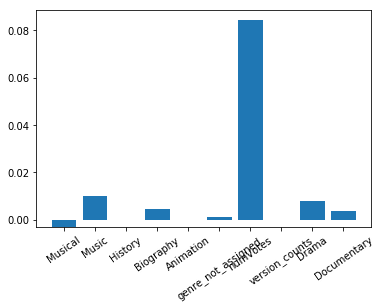

In [260]:
# Visualizing top 10 featurs by lasso coeff:

top_n_idx = lasso_model_genres.coef_.argsort()[-10:]
cols = data_titles_with_genres.columns.tolist()
cols.remove('averageRating')
top_n_feat = np.array(cols)[top_n_idx]
for i in range(len(top_n_feat)):
    if top_n_feat[i] in list(name_basics['nconst']):
        top_n_feat[i] = name_basics[name_basics['nconst']==top_n_feat[i]]['primaryName'].iloc[0]

plt.bar(np.arange(0,len(top_n_idx), 1), lasso_model.coef_[top_n_idx])
plt.xticks(np.arange(0,len(top_n_idx), 1), top_n_feat, rotation=35)
plt.show()

<b> The graph says that the rating of the movie is greatly influenced by number of votes, and the genre of the movie

##### 7(d) We see that adding genres data gives a huge boost in the r2 score. <br> So it would be better to see the results obtained by using Random Forest and Adaboost regression too


<b> <u>Note</u>: I am tuning only on hyperparameter (n_estimtors) due to computing and time constraints

In [457]:
## Trying RandomForest Regression and Adaboost Regression

# Cross validation
n_estimators = np.arange(10, 150, 10)
adaboost_regressor_score_list = CrossValidationOnASelectedModelII('AdaBoostRegressor', X_train, y_train, n_estimators, 5)
print('adaboost reg done')
rf_regressor_score_list = CrossValidationOnASelectedModelII('RandomForestRegressor', X_train, y_train, n_estimators, 5)
print("random forests reg done")

# Extracting the best n_estimators value
adaboost_reg_best_n_estimators = getBestHyperparameterVal(adaboost_regressor_score_list, n_estimators)
rf_reg_best_n_estimators = getBestHyperparameterVal(rf_regressor_score_list, n_estimators)

adaboost reg done
random forests reg done


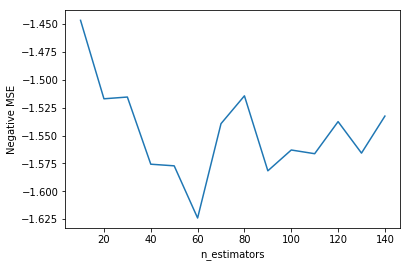

In [458]:
# Plotting n_estimators vs the score

plt.plot(n_estimators, adaboost_regressor_score_list)
plt.xlabel('n_estimators')
plt.ylabel('Negative MSE')
plt.show()

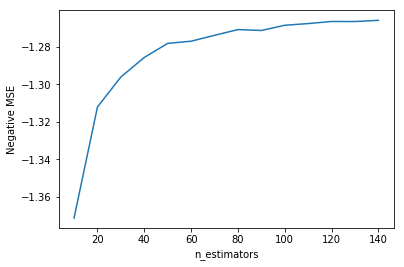

In [459]:
plt.plot(n_estimators, rf_regressor_score_list)
plt.xlabel('n_estimators')
plt.ylabel('Negative MSE')
plt.show()

In [455]:
# Training on the two ensemble models
adaboost_regressor_model = trainAndTestAModelII('AdaBoostRegressor', adaboost_reg_best_n_estimators, X_train, y_train, X_test, y_test)
rf_regressor_model = trainAndTestAModelII('RandomForestRegressor', rf_reg_best_n_estimators, X_train, y_train, X_test, y_test)

The mean squared error for AdaBoostRegressor is : 1.4813410221
The r2 score for AdaBoostRegressor is : 0.14398511608
The mean squared error for RandomForestRegressor is : 1.28587775251
The r2 score for RandomForestRegressor is : 0.256936465924


<b>We see that the new r2 score is 25 times than the baseline score. This conveys that genres is a very important indicator while estimating the movie ratings. The below graph also says the same thing:

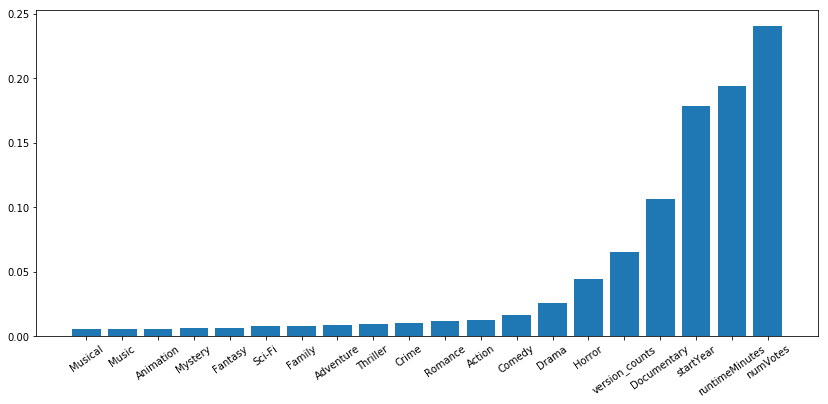

In [454]:
feature_imp_coeff = rf_regressor_model.feature_importances_

plt.figure(figsize=(14,6))
top_n_idx = feature_imp_coeff.argsort()[-20:]
cols = data_titles_with_genres.columns.tolist()
cols.remove('averageRating')
top_n_feat = np.array(cols)[top_n_idx]
for i in range(len(top_n_feat)):
    if top_n_feat[i] in list(name_basics['nconst']):
        top_n_feat[i] = name_basics[name_basics['nconst']==top_n_feat[i]]['primaryName'].iloc[0]

plt.bar(np.arange(0,len(top_n_idx), 1), feature_imp_coeff[top_n_idx])
plt.xticks(np.arange(0,len(top_n_idx), 1), top_n_feat, rotation=35)
plt.show()

## 8 Genres and directors data together

<b> We have seen that the model performs a lot better the addition of genres data and somewhat better with directors data. Hence I am experimenting by merging both of them and then training the models

##### 8(a) Data preprocessing

In [343]:
data_with_directors_II = pd.concat([data, df_directors], axis=1)
data_titles_with_genres = add_genres_df(unique_genres, genre_df, data_titles_only_movies)
data_titles_with_genres = data_titles_with_genres.drop(axis=1, columns=['genres'])
data_titles_with_genres = data_titles_with_genres.fillna(value={'version_counts':1})
data_titles_with_genres = data_titles_with_genres.rename(columns={'\\N': 'genre_not_assigned'})

In [360]:
# removing the overlapping columns before performing merging 

common_cols = list(set((data_with_directors_II.columns.tolist())).intersection(data_titles_with_genres.columns.tolist()))
common_cols.remove('tconst')
cols_to_keep = list(set(data_with_directors_II.columns.tolist()) - set(common_cols))

# merging
data_titles_with_genres_and_dirs = pd.merge(data_titles_with_genres, data_with_directors_II[cols_to_keep], on='tconst', how='left')

In [361]:
data_titles_with_genres_and_dirs = data_titles_with_genres_and_dirs.dropna()
data_titles_with_genres_and_dirs = pd.merge(ratings_movie, data_titles_with_genres_and_dirs, on='tconst', how='left')
data_titles_with_genres_and_dirs = data_titles_with_genres_and_dirs.drop(axis=1, columns=['tconst', 'primaryTitle', 'originalTitle', 'endYear', 'titleType'])
data_titles_with_genres_and_dirs = removeRowsWithEmptyValues(data_titles_with_genres_and_dirs)

In [427]:
# data_titles_with_genres_and_dirs = data_titles_with_genres_and_dirs.dropna().reset_index(drop=True)
data_titles_with_genres_and_dirs.head(3)

,averageRating_x,numVotes_x,isAdult,startYear,runtimeMinutes,version_counts,Action,Adult,Adventure,Animation,...,nm0401680,nm0782947,nm0282984,nm0002194,nm0285946,nm0766211,nm0858873,nm0416258,nm0075318,nm0814469
0,5.5,79,0.0,1894,45,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.2,291,0.0,1897,20,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.2,508,0.0,1906,70,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### 8(b) data preparation for training

In [433]:
# Creating train and test datasets and running the model

X, y = prepareData(data_titles_with_genres_and_dirs, 'averageRating_x')
# Standardizing the datasets:
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

##### 8(c) Training phase

In [437]:
alpha_range = np.exp(np.arange(0.001,-10,-0.75))
lasso_score_list = CrossValidationOnASelectedModel('Lasso', X_train, y_train, alpha_range, 5)
print("lasso - done")
ridge_score_list = CrossValidationOnASelectedModel('Ridge', X_train, y_train, alpha_range, 5)
print("ridge - done")
lasso_best_alpha_genres_and_dirs = getBestHyperparameterVal(lasso_score_list, alpha_range)
ridge_best_alpha_genres_and_dirs = getBestHyperparameterVal(ridge_score_list, alpha_range)

lasso - done
ridge - done


<b> (i) training ols, lasso, ridge

In [438]:
ols = trainAndTestAModel('LinearRegression', -1, X_train, y_train, X_test, y_test, False)
lasso_model_genres_and_dirs = trainAndTestAModel('Lasso', lasso_best_alpha_genres_and_dirs, X_train, y_train, X_test, y_test, True)
ridge_model_genres_and_dirs = trainAndTestAModel('Ridge', ridge_best_alpha_genres_and_dirs, X_train, y_train, X_test, y_test, True)

The mean squared error for LinearRegression is : 1.35530731487
The r2 score for LinearRegression is : 0.216815563398
The mean squared error for Lasso is : 1.38984467377
The r2 score for Lasso is : 0.196857638227
The mean squared error for Ridge is : 1.35530718231
The r2 score for Ridge is : 0.216815639998


<b> (ii) training rf, and adboost

<b> cross validating random forest and adaboost trees takes a lot of time (more than 2 hours).Hence I am using the n_estimators value that performed the best in section 7
<ul><li>Random forests = 150</li><li>adaboost = 10</li></ul>

In [439]:
adaboost_regressor_model_genres_and_dirs = trainAndTestAModelII('AdaBoostRegressor', 10, X_train, y_train, X_test, y_test)
rf_regressor_model_genres_and_dirs = trainAndTestAModelII('RandomForestRegressor', 150, X_train, y_train, X_test, y_test)

The mean squared error for AdaBoostRegressor is : 1.45765872338
The r2 score for AdaBoostRegressor is : 0.157670283699
The mean squared error for RandomForestRegressor is : 1.27379252867
The r2 score for RandomForestRegressor is : 0.263920091796


<b>r2 score increased sligthly from 0.25 (with genres data) to 0.26 (with genres and director data)

<ul><li><b>Plotting the top 10 siginificant features using the 'feature__importance_' attribute of random forests regression


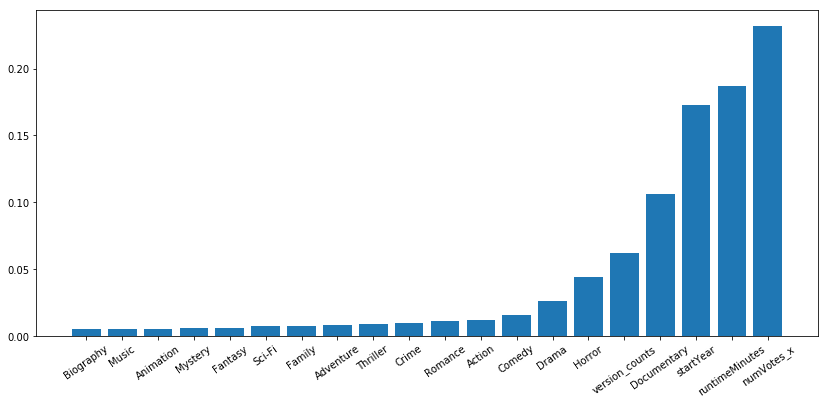

In [453]:
feature_imp_coeff = rf_regressor_model_genres_and_dirs.feature_importances_

plt.figure(figsize=(14,6))
top_n_idx = feature_imp_coeff.argsort()[-20:]
cols = data_titles_with_genres_and_dirs.columns.tolist()
cols.remove('averageRating_x')
top_n_feat = np.array(cols)[top_n_idx]
for i in range(len(top_n_feat)):
    if top_n_feat[i] in list(name_basics['nconst']):
        top_n_feat[i] = name_basics[name_basics['nconst']==top_n_feat[i]]['primaryName'].iloc[0]

plt.bar(np.arange(0,len(top_n_idx), 1), feature_imp_coeff[top_n_idx])
plt.xticks(np.arange(0,len(top_n_idx), 1), top_n_feat, rotation=35)
plt.show()

<b><ul><li>As expected, genres again have higher coefficients compared to directors data</li><li>Hence, merging genres and directors increased r2 score very slightly from 0.25 to 0.26</li></ul>

## 9. Visualizing using the best model (plotting actuals vs predicted)

<b> The model that performed the best is random forest regressor with 150 trees. Visually, its performce on the test set is shown below:

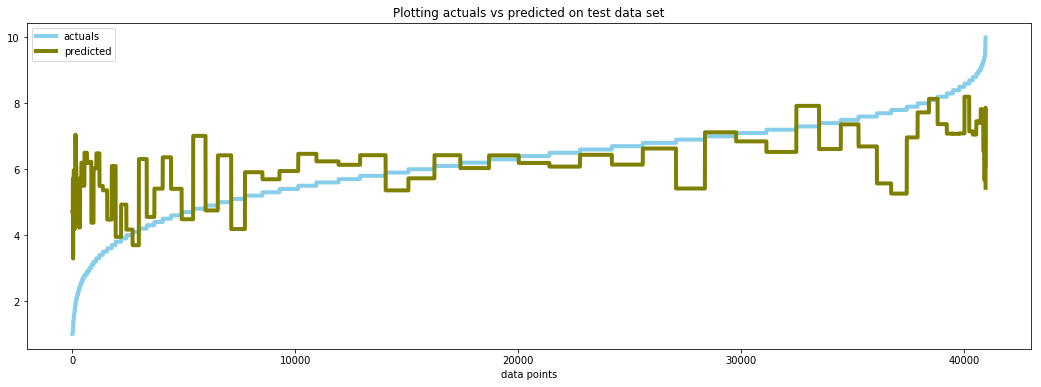

In [460]:
y_pred = rf_regressor_model_genres_and_dirs.predict(X_test)
plot_data = dict(zip(y_test, y_pred))
keys = sorted(y_test)
vals = []
for key in keys:
    vals.append(plot_data[key])
    
plt.figure(figsize=(18,6))
plt.xlabel('data points')
plt.title('Plotting actuals vs predicted on test data set')
# plt.scatter(np.arange(0,len(keys),1),keys)
# plt.scatter(keys, vals)
plt.plot(np.arange(0,len(keys),1),keys, color='skyblue', linewidth=4, label='actuals')
plt.plot(np.arange(0,len(vals),1),vals, color='olive', linewidth=4, label='predicted')
plt.legend()
plt.show()

<b> We can see that the plot for actuals and predicted values are superimposed. Hence, visually, the model seens to be performing remarkably well.

## 10. Conclusion:

<b><ul><li>From above analysis of imdb data, we can say that genres of the movie greatly influence it's rating. Directors of the movie, are also a useful indicator for the movie ratings, but not as significant as genres.</li>
<li>The r2 score increments from 0.01 (in the baseline model) to 0.03, 0.25 and finally to 0.26 by adding important features such as directors data info, genre info, and both of genres and director info.</li>
<li>The final maximum r2 score obtained is <u>0.26 which is nearly 26 times higher than the baseline r2 score of 0.01</u></li></ul>

## 11. Future Work

<ol>
<li> While procesing on the dataset (with directors info), I wanted to use Random Forest and Adaboost regression. But they were taking a lot of time to complete train and I had to forgo them</li>
<li> I wanted to add actors info as well as presence of certain actors in the movie greatly affects the movie ratings. For example: a movie which has Brad Pitt, Will Smith or Tom Hanks as their actor(s), the movie will recieve a relatively positive response from the audience. </li>
<li> While processing on the dataset (with genres data), I wanted to experiment with more n_estimator range values. I strongly feel that experimenting with more number of estimators in random forests regression, would have greatly increased the r2 score. This can be seen in the above plot of Negative MSE vs n_estimators  </li>
<li> Perform dimensionality reduction techniques like PCA or t-SNE before the training process and compare the performance </li>
<li> Explore other datasets which contains the reviews for the movies. Performing review analysis can give us more information by understanding the sentiment attached with the reviews  </li>
</ol>